## Task 2 & Task 3

### Task 2 Review Sentiment Classification

In Task 2, using data collected in Task 1 to perform the classification of positive/negative.

In [79]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
%matplotlib inline

##### Data Loading

In [80]:
df = pd.read_csv('dataset.csv')
df.head(5)

,title,body,rating,helpful_user_num,total_user_num
0,The herbs were great...but the cherry tomatoes...,The herb kit that came with my Aerogarden was ...,2,15,17
1,Even more useful than regular parchment paper,I originally bought this just because it was c...,5,19,19
2,Shake it before you bake it,"If you do it in reverse (bake before shaking),...",2,2,13
3,Not what the picture describes,I bought this steak for my father in law for C...,2,7,14
4,What a ripe off - GIVE ME A BREAK,Sorry but I had these noodles and they are no ...,2,10,34


##### Data Verification

Detect whether there is a null value

In [81]:
df.isnull().values.any()

False

Assign label (“positive” or “negative”) to each review. 

1-star to 3-star: “negative” 
4-star to 5-star: “positive” 

In [82]:
label = []
for rating in df['rating']:
    if(rating >= 4):
        label.append('positive')
    else:
        label.append('negative')

df['is_positive'] = label
df.head(5)

,title,body,rating,helpful_user_num,total_user_num,is_positive
0,The herbs were great...but the cherry tomatoes...,The herb kit that came with my Aerogarden was ...,2,15,17,negative
1,Even more useful than regular parchment paper,I originally bought this just because it was c...,5,19,19,positive
2,Shake it before you bake it,"If you do it in reverse (bake before shaking),...",2,2,13,negative
3,Not what the picture describes,I bought this steak for my father in law for C...,2,7,14,negative
4,What a ripe off - GIVE ME A BREAK,Sorry but I had these noodles and they are no ...,2,10,34,negative


Concatenate review’s title and body text:


In [83]:
df['review'] = df['title'] + df['body']
df.head(5)

,title,body,rating,helpful_user_num,total_user_num,is_positive,review
0,The herbs were great...but the cherry tomatoes...,The herb kit that came with my Aerogarden was ...,2,15,17,negative,The herbs were great...but the cherry tomatoes...
1,Even more useful than regular parchment paper,I originally bought this just because it was c...,5,19,19,positive,Even more useful than regular parchment paperI...
2,Shake it before you bake it,"If you do it in reverse (bake before shaking),...",2,2,13,negative,Shake it before you bake itIf you do it in rev...
3,Not what the picture describes,I bought this steak for my father in law for C...,2,7,14,negative,Not what the picture describesI bought this st...
4,What a ripe off - GIVE ME A BREAK,Sorry but I had these noodles and they are no ...,2,10,34,negative,What a ripe off - GIVE ME A BREAKSorry but I h...


##### Data Preprocessing

Text in the dataset may contain numbers, special characters, and unwanted spaces. Try to remove special characters, numbers, and unwanted spaces from our text. 

In [84]:
# convert all character to lowercase
df['review'] = df['review'].str.lower()
# get rid of leading or trailing white spaces
df['review'] = df['review'].str.strip()
# remove characters other than words
df['review'].replace('[^\w\s]', '', regex=True, inplace=True)
# Removing prefixed 'b'
df['review'].replace('^b\s+', '', regex=True, inplace=True)
df.head(5)

,title,body,rating,helpful_user_num,total_user_num,is_positive,review
0,The herbs were great...but the cherry tomatoes...,The herb kit that came with my Aerogarden was ...,2,15,17,negative,the herbs were greatbut the cherry tomatoesnot...
1,Even more useful than regular parchment paper,I originally bought this just because it was c...,5,19,19,positive,even more useful than regular parchment paperi...
2,Shake it before you bake it,"If you do it in reverse (bake before shaking),...",2,2,13,negative,shake it before you bake itif you do it in rev...
3,Not what the picture describes,I bought this steak for my father in law for C...,2,7,14,negative,not what the picture describesi bought this st...
4,What a ripe off - GIVE ME A BREAK,Sorry but I had these noodles and they are no ...,2,10,34,negative,what a ripe off give me a breaksorry but i ha...


Define lemmatization method for further use

In [85]:
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append(lemmatizer.lemmatize(token))
    return lemma_tokens

Create a new dataframe to store review and label for classification

In [86]:
df_review = df[['review', 'is_positive']].copy()
df_review.head(5)

,review,is_positive
0,the herbs were greatbut the cherry tomatoesnot...,negative
1,even more useful than regular parchment paperi...,positive
2,shake it before you bake itif you do it in rev...,negative
3,not what the picture describesi bought this st...,negative
4,what a ripe off give me a breaksorry but i ha...,negative


Split the dataset to a training set and testing set (33%) for further evaluation.

In [87]:
train, test = train_test_split(df_review, test_size=0.33)

Set the data and target part for the dataset.

In [88]:
data_train, target_train = train['review'], train['is_positive']
data_test, target_test = test['review'], test['is_positive']

Using bag of words (BOW) method: TF-IDF. Produce vector representations of the documents, since we care about the frequency of the words in text reviews

In [89]:
vectorizer = TfidfVectorizer(stop_words="english", tokenizer=lemma_tokenizer)
data_train = vectorizer.fit_transform(data_train)
data_test = vectorizer.transform(data_test)

c:\Users\Steve\anaconda3\envs\comp47670\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [90]:
print("Training set has %d examples" % data_train.shape[0] )
print("Test set has %d examples" % data_test.shape[0] )

Training set has 6193 examples
Test set has 3051 examples


#### 1. k-NN classification

Prepare the k-NN classification model, for 3 nearest neighbours in this case:

In [91]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(data_train, target_train)

KNeighborsClassifier(n_neighbors=3)

Make predictions for reviews in the test set.

In [92]:
predicted = model.predict(data_test)
predicted

array(['negative', 'positive', 'negative', ..., 'negative', 'positive',
       'negative'], dtype=object)

In [93]:
print("k-NN's Accuracy = %.4f" % accuracy_score(target_test, predicted))

k-NN's Accuracy = 0.7211


Visualize the confusion matrix to see where the errors lie:

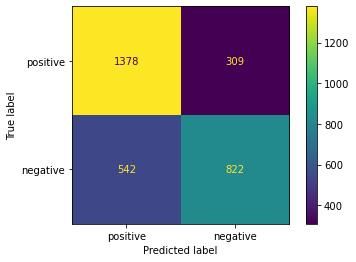

In [94]:
# calculate the matrix 
cm = confusion_matrix(target_test, predicted, labels=['positive', 'negative'])
# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=['positive', 'negative'])
cmd.plot();

The scale of false positive is greater than false negative.

Invoke *classification_report()* function for summarising all evaluation metrics.

In [95]:
print("K-NN scores: \n")
print(classification_report(target_test, predicted, target_names=['positive', 'negative']))

K-NN scores: 

              precision    recall  f1-score   support

    positive       0.73      0.60      0.66      1364
    negative       0.72      0.82      0.76      1687

    accuracy                           0.72      3051
   macro avg       0.72      0.71      0.71      3051
weighted avg       0.72      0.72      0.72      3051



Using *k-fold cross-validation* to evaluate.

In [96]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10)
# note that we pass RepeatedKFold as the parameter cv

documents = df_review['review']
X = vectorizer.fit_transform(documents)
# Class labels for all documents
target = df_review['is_positive']
repeated_acc_scores = cross_val_score(model, X, target, cv=rkf, scoring="accuracy")

In [97]:
s_racc = pd.Series(repeated_acc_scores)
s_racc.head(20)

0     0.730665
1     0.724175
2     0.742564
3     0.733369
4     0.748377
5     0.746349
6     0.733369
7     0.735533
8     0.730665
9     0.728355
10    0.734451
11    0.731206
12    0.733910
13    0.735533
14    0.740260
15    0.729043
16    0.749054
17    0.726339
18    0.730124
19    0.740801
dtype: float64

Calculate the mean over all values in the Data Frame:

In [98]:
print("Overall mean accuracy of k-NN: %.4f" % s_racc.mean() )
print("Overall standard deviation in accuracy: %.4f" % s_racc.std() )

Overall mean accuracy of k-NN: 0.7340
Overall standard deviation in accuracy: 0.0092


After cross validation, the average accuracy is about 73%, which is a little low for prediction.

#### 2. Support Vector Machines (SVM) classification

Using SVM to fit the training data for prediction.

In [99]:
svc = SVC(kernel='linear')
svc.fit(data_train, target_train)

SVC(kernel='linear')

Make predictions for reviews in the testing data.

In [100]:
predicted = svc.predict(data_test)
predicted

array(['negative', 'positive', 'positive', ..., 'negative', 'positive',
       'positive'], dtype=object)

In [101]:
print("SVM's Accuracy = %.4f" % accuracy_score(target_test, predicted))

SVM's Accuracy = 0.8538


Visualize the confusion matrix to see where the errors lie:

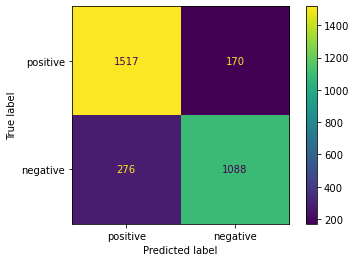

In [102]:
# calculate the matrix 
cm = confusion_matrix(target_test, predicted, labels=['positive', 'negative'])
# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=['positive', 'negative'])
cmd.plot();

Invoke *classification_report()* function for summarising all evaluation metrics.

In [103]:
print("SVM scores: \n")
print(classification_report(target_test, predicted, target_names=['positive', 'negative']))

SVM scores: 

              precision    recall  f1-score   support

    positive       0.86      0.80      0.83      1364
    negative       0.85      0.90      0.87      1687

    accuracy                           0.85      3051
   macro avg       0.86      0.85      0.85      3051
weighted avg       0.85      0.85      0.85      3051



F1 Score is the weighted average of Precision and Recall. Accuracy is preferred when the True Positive and True negative prediction are more important while F1-score is preferred when the False Negatives and False Positives are crucial. Also, F1 takes into account how the data is distributed

We can observe that the accuracy of Support Vector Machines is much higher than k-NN.

SVM performs well in this review dataset. 

Using *k-fold cross-validation* to evaluate.

In [104]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
# Too long to execute: 8 mins+
repeated_acc_scores = cross_val_score(svc, X, target, cv=rkf, scoring="accuracy")

In [105]:
s_racc = pd.Series(repeated_acc_scores)
s_racc.head(20)

0     0.859924
1     0.863169
2     0.865333
3     0.852353
4     0.866883
5     0.869118
6     0.863169
7     0.865873
8     0.846944
9     0.858225
10    0.862628
11    0.862088
12    0.864251
13    0.868578
14    0.864719
15    0.869118
16    0.863169
17    0.862628
18    0.859383
19    0.854978
dtype: float64

Calculate the mean over all values in the Data Frame:

In [106]:
print("Overall mean accuracy of SVM: %.4f" % s_racc.mean() )
print("Overall standard deviation in accuracy: %.4f" % s_racc.std() )

Overall mean accuracy of SVM: 0.8621
Overall standard deviation in accuracy: 0.0051


After cross validation, the average accuracy value of SVM for review prediction is 86%, which is 13% higher than k-NN classifier.

However, executing SCM classification is much lower than k-NN, especially in k-fold. The performance should be considered in advanced for production use.

### Task 3 Review Helpfulness Classification

Similar to review classification, using number of users who think this comment is useful and number of total number of pusers who have seen this review. 

The partition criteria: if more than 60% of people think this data is useful, it will be marked as "helpful", otherwise it will be marked as "unhelpful".

In [107]:
df_user = df[['helpful_user_num', 'total_user_num']]
df_user['helpful_rate'] = df_user['helpful_user_num'] / df_user['total_user_num']
helpful_label = []
for rate in df_user['helpful_rate']:
    if rate >= 0.6:
        helpful_label.append('helpful')
    else:
        helpful_label.append('unhelpful')
df['is_helpful'] = helpful_label
df.head(5)

C:\Users\Steve\AppData\Local\Temp\ipykernel_14340\1261609403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['helpful_rate'] = df_user['helpful_user_num'] / df_user['total_user_num']


,title,body,rating,helpful_user_num,total_user_num,is_positive,review,is_helpful
0,The herbs were great...but the cherry tomatoes...,The herb kit that came with my Aerogarden was ...,2,15,17,negative,the herbs were greatbut the cherry tomatoesnot...,helpful
1,Even more useful than regular parchment paper,I originally bought this just because it was c...,5,19,19,positive,even more useful than regular parchment paperi...,helpful
2,Shake it before you bake it,"If you do it in reverse (bake before shaking),...",2,2,13,negative,shake it before you bake itif you do it in rev...,unhelpful
3,Not what the picture describes,I bought this steak for my father in law for C...,2,7,14,negative,not what the picture describesi bought this st...,unhelpful
4,What a ripe off - GIVE ME A BREAK,Sorry but I had these noodles and they are no ...,2,10,34,negative,what a ripe off give me a breaksorry but i ha...,unhelpful


Create a new dataframe to store review and helpful tag:

In [108]:
df_helpful = df[['review', 'is_helpful']].copy()
df_helpful.head(5)

,review,is_helpful
0,the herbs were greatbut the cherry tomatoesnot...,helpful
1,even more useful than regular parchment paperi...,helpful
2,shake it before you bake itif you do it in rev...,unhelpful
3,not what the picture describesi bought this st...,unhelpful
4,what a ripe off give me a breaksorry but i ha...,unhelpful


Set the data and target for the dataset.

Use bag of words (BOW) method: TF-IDF , produce vector representations of the documents

Split the dataset to a training set and testing set (33%) for further evaluation.

In [109]:
documents = df_helpful['review']
target = df_helpful['is_helpful']
target_categories = ["helpful", "unhelpful"]

ectorizer = TfidfVectorizer(stop_words="english", tokenizer=lemma_tokenizer)
X = vectorizer.fit_transform(documents)
# Class labels for all documents
data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
print("Training set has %d examples" % data_train.shape[0] )
print("Test set has %d examples" % data_test.shape[0] )

Training set has 6193 examples
Test set has 3051 examples


#### 1. k-NN classification

Prepare the k-NN classification model, for 3 nearest neighbours in this case:

In [110]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(data_train, target_train)

KNeighborsClassifier(n_neighbors=3)

Make predictions for helpfulness in the test set.

In [111]:
predicted = model.predict(data_test)
predicted

array(['helpful', 'helpful', 'helpful', ..., 'helpful', 'helpful',
       'helpful'], dtype=object)

In [112]:
print("k-NN's Accuracy of Helpfullness = %.4f" % accuracy_score(target_test, predicted))

k-NN's Accuracy of Helpfullness = 0.7955


Visualize the confusion matrix to see where the errors lie:

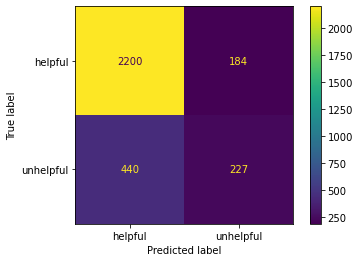

In [113]:
# calculate the matrix 
cm = confusion_matrix(target_test, predicted, labels=target_categories)
# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot();

Invoke *classification_report()* function for summarising all evaluation metrics.

In [114]:
print("K-NN scores: \n")
print(classification_report(target_test, predicted, target_names=target_categories))

K-NN scores: 

              precision    recall  f1-score   support

     helpful       0.83      0.92      0.88      2384
   unhelpful       0.55      0.34      0.42       667

    accuracy                           0.80      3051
   macro avg       0.69      0.63      0.65      3051
weighted avg       0.77      0.80      0.78      3051



The accuracy value is higher than result of predicting review (73%).

Using *k-fold cross-validation* to evaluate.

In [115]:
# note that we pass RepeatedKFold as the parameter cv
rkf = RepeatedKFold(n_splits=5, n_repeats=10)
repeated_acc_scores = cross_val_score(model, X, target, cv=rkf, scoring="accuracy")

In [116]:
s_racc = pd.Series(repeated_acc_scores)
s_racc.head(20)

0     0.803678
1     0.812331
2     0.815035
3     0.812872
4     0.816017
5     0.811790
6     0.810708
7     0.804759
8     0.805841
9     0.799784
10    0.819362
11    0.805300
12    0.820443
13    0.804218
14    0.805736
15    0.828015
16    0.796106
17    0.803678
18    0.817198
19    0.817100
dtype: float64

Calculate the mean over all values in the Data Frame:

In [117]:
print("Overall mean accuracy of k-NN: %.4f" % s_racc.mean() )
print("Overall standard deviation in accuracy: %.4f" % s_racc.std() )

Overall mean accuracy of k-NN: 0.8105
Overall standard deviation in accuracy: 0.0089


Compared with predicting review, the result of predicing of helpfulness is higher, which also results in lower standard deviation.

#### 2. Support Vector Machines (SVM) classification

In [118]:
svc = SVC(kernel='linear')
svc.fit(data_train, target_train)

SVC(kernel='linear')

Make predictions for reviews in the test set.

In [119]:
predicted = svc.predict(data_test)
predicted

array(['helpful', 'helpful', 'helpful', ..., 'helpful', 'helpful',
       'unhelpful'], dtype=object)

In [120]:
print("SVM's Accuracy = %.4f" % accuracy_score(target_test, predicted))

SVM's Accuracy = 0.8315


Visualize the confusion matrix to see where the errors lie:

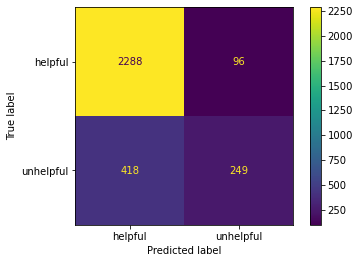

In [121]:
# calculate the matrix 
cm = confusion_matrix(target_test, predicted, labels=target_categories)
# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot();

Invoke *classification_report()* function for summarising all evaluation metrics.

In [122]:
print("SVM scores: \n")
print(classification_report(target_test, predicted, target_names=['positive', 'negative']))

SVM scores: 

              precision    recall  f1-score   support

    positive       0.85      0.96      0.90      2384
    negative       0.72      0.37      0.49       667

    accuracy                           0.83      3051
   macro avg       0.78      0.67      0.70      3051
weighted avg       0.82      0.83      0.81      3051



We can see that the accuracy of Support Vector Machines is higher than k-NN but it is close (81% for k-NN).


Using *k-fold cross-validation* to evaluate.

In [123]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
# Too long to execute: 8 mins+
repeated_acc_scores = cross_val_score(svc, X, target, cv=rkf, scoring="accuracy")

In [124]:
s_racc = pd.Series(repeated_acc_scores)
s_racc.head(20)

0     0.843699
1     0.851271
2     0.836128
3     0.833423
4     0.824134
5     0.844240
6     0.850189
7     0.838832
8     0.826933
9     0.833333
10    0.844240
11    0.843158
12    0.844240
13    0.832342
14    0.849567
15    0.825311
16    0.839913
17    0.840995
18    0.838832
19    0.852273
dtype: float64

Calculate the mean over all values in the Data Frame:

In [125]:
print("Overall mean accuracy of SVM: %.4f" % s_racc.mean() )
print("Overall standard deviation in accuracy: %.4f" % s_racc.std() )

Overall mean accuracy of SVM: 0.8404
Overall standard deviation in accuracy: 0.0084


From the result, we can observe that, the accuracy of SVM classifier is higher than k-NN, and the F1-score of SVC is also higher. Overall, SVC performs much better  than k-NN in text classification. However, the performance of k-NN is much better than SVC (10 seconds and 10 mins for cross validation).

Since different dataset contains their own feature, for practical use, maybe more classifier should be tried and get better results.